<h1>Word2Vecf on Chess Puzzle Data</h1>

In [1]:
#Word 2 Vec F test
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

TRAIN_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/train_full_set'
CONTEXT_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/cv_full_set'
VOCAB_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/wv_full_set'
PPMI_TAB = '/w/225/1/chess/tactics/parameter_tuning_files/sample_pairs_ppmi'

<h2>Load, Filter, Save Data for Loading to Word2vecf</h2>

In [ ]:
#Load Data
chess_data = pd.read_csv('/w/225/1/chess/tactics/glicko_user_tactics_problem.csv_00')

In [ ]:
#Filter Data
chess_data = chess_data[chess_data.is_passed == 1]

In [ ]:
len(chess_data)

In [ ]:
#Create vocabulary file for word2vecf
vocab_dat = chess_data.groupby('tactics_problem_id')['user_hash'].nunique().to_frame()
#Number of vocab words in 'corpus'
len(vocab_dat.index)

In [ ]:
#Get the count of puzzles attempted per each user, ie create the context file for word2vecf
context_dat = chess_data.groupby('user_hash')['tactics_problem_id'].nunique().to_frame()
context_dat.head()

In [ ]:
#Write to CSV the training, vocab and context data
#Convert indexes to columns
vocab_dat.reset_index(level=0, inplace=True)
vocab_dat.to_csv(VOCAB_DAT,
                 sep=' ',
                 index=False,
                 header=False,
                 encoding='utf-8')

In [ ]:
context_dat.reset_index(level=0,inplace=True)
context_dat.to_csv(CONTEXT_DAT,
                 sep=' ',
                 index=False,
                 header=False,
                 encoding='utf-8')

In [ ]:
#Filter and reorder columns
#chess_data = chess_data.filter(items=['user_hash','tactics_problem_id'])
chess_data = chess_data[['tactics_problem_id','user_hash']]
chess_data.head()
chess_data.to_csv(TRAIN_DAT,
                 sep=' ',
                 index=False,
                 header=False,
                 encoding='utf-8')

<h2>Create Pairs of random vocab words to generate PPMIs</h2>

In [102]:
#Create a bunch of random pairs of 
pairs_to_sample = 1000000 # will be less b.c. duplicates
#vocab_dat = vocab_dat.set_index('tactics_problem_id')
pairs = np.random.choice(vocab_dat.index, (pairs_to_sample,2))
pairs = pairs[pairs[:, 0] != pairs[:, 1]]
print(pairs[:5])
print(pairs.shape)

[[159895  63342]
 [120701  84914]
 [ 59774  97619]
 [115842 166214]
 [130142 183507]]
(999989, 2)


In [104]:
#Join pairs with their user counts for each puzzle
pmi_table = pd.DataFrame(data=pairs,columns=["puz_a","puz_b"])
pmi_table = pd.merge(pmi_table,vocab_dat,how='left',left_on='puz_a',right_on='tactics_problem_id')
#mi_table.columns = ['puz_a','puz_b','users_a',]
pmi_table = pd.merge(pmi_table,vocab_dat,how='left',left_on='puz_b',right_on='tactics_problem_id')
pmi_table.columns = ['puz_a','puz_b','users_a','users_b']
pmi_table.head()

,puz_a,puz_b,users_a,users_b
0,159895,63342,3006,2516
1,120701,84914,3982,2850
2,59774,97619,4389,1560
3,115842,166214,4061,117
4,130142,183507,2532,213


In [80]:
#Sort for speeding up finding counts of shared users later
chess_data.sort_values(by="tactics_problem_id",inplace=True)
chess_data.head()

,tactics_problem_id,user_hash
10905403,731,83f328ec5627b146c51b7115493332eba6132692e911fa...
30975168,731,1cdf809577062352e1c6aedc7e8c6979e75775585923a3...
16416117,731,925184f476c094bc7bfd348dbb3f23512952fdc679d1bd...
126555710,731,1ecc2214ac2c6055788091af105dcd78cec8629e3352d6...
10832985,731,50650667f2ae361a53d05ee1107ffabe0426c173695255...


In [86]:
#Drop Index
#chess_data = chess_data.reset_index()
chess_data = chess_data.drop('index',axis=1)
chess_data.head()

,tactics_problem_id,user_hash
0,731,83f328ec5627b146c51b7115493332eba6132692e911fa...
1,731,1cdf809577062352e1c6aedc7e8c6979e75775585923a3...
2,731,925184f476c094bc7bfd348dbb3f23512952fdc679d1bd...
3,731,1ecc2214ac2c6055788091af105dcd78cec8629e3352d6...
4,731,50650667f2ae361a53d05ee1107ffabe0426c173695255...


In [131]:
#Calculate number of users that have completed both puzzles for each pair
import time
def get_shared_user(row):
    #temp = chess_data[(chess_data['tactics_problem_id'] == row['puz_a']) | (chess_data['tactics_problem_id'] == row['puz_b'])]
    #return(len(temp[temp.duplicated(['user_hash'])]))
    #Option B, slightly slower
    #user_a = chess_data[chess_data['tactics_problem_id'] == row['puz_a']]
    #user_b = chess_data[chess_data['tactics_problem_id'] == row['puz_b']]
    #return(len(pd.merge(user_a,user_b,how='inner',on='user_hash')))
    #Option C, requires sorted list, fastest
    a_start = np.searchsorted(chess_data['tactics_problem_id'],row['puz_a'])[0]
    #print(a_first_index)
    b_start = np.searchsorted(chess_data['tactics_problem_id'],row['puz_b'])[0]
    user_a = chess_data.iloc[a_start:a_start+row['users_a']]
    user_b = chess_data.iloc[b_start:b_start+row['users_b']]
    return(len(pd.merge(user_a,user_b,how='inner',on='user_hash')))

start = time.time()
pmi_table['users_a_b'] = pmi_table.progress_apply(lambda row: get_shared_user(row),axis=1)
end = time.time()
print(end-start)

4512.267183065414


In [134]:
pmi_table.shape

(999989, 5)

In [135]:
#Calculate pointwise mutual information for each pair
def calc_pmi(row,vocab_len):
    if(row['users_a_b'] == 0): return 0
    return np.log(row['users_a_b']) + vocab_len - np.log(row['users_a']) - np.log(row['users_b'])

vocab_len = np.log(len(vocab_dat.index))
pmi_table['pmi'] = pmi_table.apply(lambda row: calc_pmi(row,vocab_len),axis=1)
#Filter out negative values to get Postivive PMI
pmi_table = pmi_table[pmi_table['pmi'] > 0]
pmi_table.head()

,puz_a,puz_b,users_a,users_b,users_a_b,pmi
0,159895,63342,3006,2516,351,0.674017
1,120701,84914,3982,2850,386,0.363246
5,52531,27906,3719,3723,505,0.433085
8,115098,155221,376,169,7,1.538444
10,29644,147189,3618,3079,716,0.999665


In [137]:
#Save PPMI
pmi_table.to_csv(,
                 encoding='utf-8')

<h2>Create embeddings for different hyperparameter combos</h2>

In [50]:
#Set up range of hyperparamters to try for tuning
param1 = "alpha"
param1_values = np.linspace(0.1, 0.3, 5)
param2 = "size"
param2_values = np.linspace(50, 250, 5)

print(param1_values)
print(param2_values)

all_embeddings = [(p1, p2) for p1 in param1_values for p2 in param2_values]

[0.1  0.15 0.2  0.25 0.3 ]
[ 50. 100. 150. 200. 250.]


In [3]:
import subprocess
import sys

def generate_embedding(tpl):
    p1, p2 = tpl
    output = f"word2vecf/vectors/size_alpha/vecs_{p1}_{p2}.txt"
    command = f"word2vecf/word2vecf -train {TRAIN_DAT} -wvocab {VOCAB_DAT} -cvocab {CONTEXT_DAT} -output {output} -threads 180 -{param1} {p1} -{param2} {p2}"
    
    subprocess.run(command, shell=True)
    
    return output
    
generated_embeddings = list(map(generate_embedding, tqdm(all_embeddings)))

In [38]:
#Load embeddings

def load_embedding(filename):
    vectors = pd.read_csv(filename, sep=' ', header=None, skiprows=1)
    #Set index to be the first column which contains the puzzle IDs
    vectors = vectors.set_index(0)
    #Get rid of empty column at end
    vectors = vectors.drop(len(vectors.columns),axis=1)
    #vectors = vectors = vectors.iloc[:, 0:200]
    #Normalize puzzle vectors
    vectors = vectors.divide(np.linalg.norm(vectors, axis=1), axis=0)
    return vectors

loaded_embeddings = list(map(lambda x: load_embedding(x), tqdm(generated_embeddings)))

In [35]:
ppmi = pd.read_csv(PPMI_TAB).drop('Unnamed: 0',axis=1)
ppmi.head()

,puz_a,puz_b,users_a,users_b,users_a_b,pmi
0,159895,63342,3006,2516,351,0.674017
1,120701,84914,3982,2850,386,0.363246
2,52531,27906,3719,3723,505,0.433085
3,115098,155221,376,169,7,1.538444
4,29644,147189,3618,3079,716,0.999665


In [39]:
#Assess PPMI

#Load PMI


def assess_ppmi(embedding):
    vecs_a = embedding.reindex(ppmi["puz_a"].astype(int))
    vecs_b = embedding.reindex(ppmi["puz_b"].astype(int))
    cosines = np.multiply(vecs_a, vecs_b).sum(1)
    ppmis = ppmi["pmi"]
    
    corr = np.corrcoef(cosines, ppmis)
    return corr[0,1]
    
    
assessment_scores = np.array(list(map(assess_ppmi, tqdm(loaded_embeddings))))

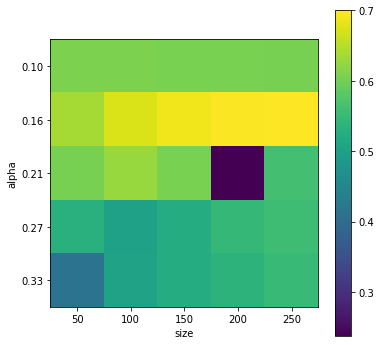

In [47]:
import matplotlib.pyplot as plt
grid = np.arange(0, len(all_embeddings)).reshape((len(param1_values), len(param2_values)))

scores = assessment_scores.copy()
plt.figure(figsize=(6,6))
plt.imshow(scores[grid])
plt.yticks(np.arange(0, len(param1_values)), ["%.2f" % d for d in param1_values])
plt.xticks(np.arange(0, len(param2_values)), ["%d" % d for d in param2_values])
plt.ylabel(param1)
plt.xlabel(param2)
plt.colorbar()
plt.show()

In [49]:
plt.savefig('5_5_correlation_matrix_size_alpha.png')

<Figure size 432x288 with 0 Axes>

<h2>Prepare Data for Projector</h2>

In [61]:
#vectors = pd.read_csv("word2vecf/vectors/dim200puzzlevec", sep=' ', header=None, skiprows=1)
#Remove Empty column at end of file

#vectors = vectors.drop(vectors.shape[1]-1,axis=1)
#Create puzzle_vocabulary data frame from first column of vectors and then remove vector id column from vectors
max_index = np.where(assessment_scores == max(assessment_scores))[0][0]
vectors = loaded_embeddings[max_index]
vectors.reset_index(level=0, inplace=True)
vectors.rename(columns={0:'tactics_problem_id'}, inplace=True)
puzzle_vocabulary_pd = vectors['tactics_problem_id'].to_frame().astype('int32').set_index("tactics_problem_id")
vectors = vectors.drop('tactics_problem_id',axis=1)

In [62]:
vectors.shape

(42278, 250)

<h2>Load Puzzle MetaData</h2>

In [63]:
#Load Fen Data
fen_data = pd.read_csv('/w/225/1/chess/tactics/tactics_problem.csv')

In [ ]:
#Extract PGN and FEN
'''
import re
old_pgn = fen_data['pgn']
new_pgn = np.array([])
for i in range(0,len(old_pgn)):
    old_fen = old_pgn[i]
    try:
        string = re.search('\[FEN \"(.+?)\"\]', old_fen).group(1)
        string = string.replace(' ','_')
        #print(string)
    except:
        string = ''
    new_pgn = np.append(new_pgn,'https://lichess.org/analysis/' + string)
print(new_pgn)
'''

In [64]:
#np.save('fen_links.npy',new_pgn)
#Add FEN Data to 
new_pgn = np.load('fen_links.npy')
fen_data['pgn'] = new_pgn
fen_data.rename(columns={'pgn':'fen'}, inplace=True)

In [65]:
#puzzle_vocabulary_pd = puzzle_vocabulary_pd.join(tag_data.set_index('tactics_problem_id'))
puzzle_vocabulary_pd = puzzle_vocabulary_pd.join(fen_data.set_index('tactics_problem_id'))

In [66]:
#IMPORTANT remove empty values, causes issues with projector
puzzle_vocabulary_pd = puzzle_vocabulary_pd.replace(np.nan, 0,regex=True)
puzzle_vocabulary_pd.reset_index(level=0, inplace=True)

In [67]:
#Set data types back to int32 for numeric columns
puzzle_vocabulary_pd.astype({'rating': 'int32','attempt_count': 'int32','average_seconds':'int32','move_count':'int32'}).dtypes
#Check for Null values
print(len(puzzle_vocabulary_pd) - puzzle_vocabulary_pd.count())
puzzle_vocabulary_pd.head()

tactics_problem_id    0
rating                0
rd                    0
attempt_count         0
average_seconds       0
move_count            0
tags                  0
fen                   0
dtype: int64


,tactics_problem_id,rating,rd,attempt_count,average_seconds,move_count,tags,fen
0,731,1569.0,44.96,53336.0,41.0,3.0,"Attacking f7/f2,Attacking Castled King,Back Ra...",https://lichess.org/analysis/r1b2rk1/ppp2ppp/1...
1,746,876.0,43.96,329720.0,46.0,1.0,Pin,https://lichess.org/analysis/r3k2r/ppp1b2p/2n1...
2,27811,1087.0,45.58,234263.0,92.0,2.0,"Decoy / Deflection,Fork / Double Attack",https://lichess.org/analysis/r4rk1/p4pp1/5q1p/...
3,905,873.0,43.31,367968.0,60.0,3.0,Remove the Defender,https://lichess.org/analysis/2r3k1/8/5P2/Q3P2p...
4,48779,1244.0,45.65,230125.0,72.0,4.0,"Decoy / Deflection,Endgame Tactics,Pawn Promot...",https://lichess.org/analysis/8/6b1/6P1/B7/P1k5...


<h2>Save Files for Projector</h2>

In [68]:
meta_name = 'dim250meta.tsv'
vec_name = 'dim250vectors.tsv'

#Save Metadata
puzzle_vocabulary_pd.to_csv(
        meta_name,
        sep='\t',
        index=False,
        header=True,
        encoding='utf-8'
    )

#Save vectors
vectors.to_csv(
        vec_name,
        sep='\t',
        index=False,
        header=False,
        encoding='utf-8'
    )

In [69]:
#Generate Config For Projector
import json
embeddings = []
embeddings.append({"tensorName": "Chess Puzzle Embeddings 2",
      "tensorShape": [
        vectors.shape[0],
        vectors.shape[1]
      ],
      "tensorPath": "https://raw.githubusercontent.com/biltmire/ChessPuzzleEmbeddings/master/" + vec_name,
      "metadataPath": "https://raw.githubusercontent.com/biltmire/ChessPuzzleEmbeddings/master/" + meta_name,
  })

with open('../../ChessPuzzleEmbeddings/puzzle_250_config.json', "w+") as text_file:
    text_file.write(json.dumps({"embeddings": embeddings}))